In [122]:
# imports
import re
from pyspark.sql import *

# initialising spark-sql context
sql_context = SQLContext(sc)

In [126]:
# reading the raw file
log_file_path = 'ggevent.log'
raw_text = sc.textFile(log_file_path)
print(raw_text.take(3))

[u'{"headers": {"ai5": "8fa683e59c02c04cb781ac689686db07", "debug": null, "random": null, "sdkv": "7.6"}, "post": {"event": "ggstart", "ts": "1462759195259"}, "params": {}, "bottle": {"timestamp": "2016-05-09 02:00:00.004906", "game_id": "55107008"}}', u'{"headers": {"ai5": "335644267c1d5f04eaea7bc6f51b1861", "debug": null, "random": null, "sdkv": "7.6"}, "post": {"event": "ggstart", "ts": "1462759189745"}, "params": {}, "bottle": {"timestamp": "2016-05-09 02:00:00.033775", "game_id": "55107008"}}', u'{"headers": {"ai5": "ca3071aad676bc963795a2b09635cdf0", "debug": null, "random": null, "sdkv": "7.6"}, "post": {"event": "ggstop", "ts": "1462768152242"}, "params": {}, "bottle": {"timestamp": "2016-05-09 02:00:00.036721", "game_id": "55107008"}}']


In [127]:
# parse_log to get the required data into tabular format
def logParse(log_pattern,log_line):
    match = re.search(log_pattern,log_line)
    return (match.group(1))

In [102]:
# log_pattern
# LOG_PATTERN = r'(\bai5\b)": "(\w*)'
LOG_PATTERN_did = r'\bai5\b": "(\w*)'
LOG_PATTERN_devent = r'\bevent\b": "(\w*)'
LOG_PATTERN_dsdk = r'\bsdkv\b": "(\w*\W\w*)'
LOG_PATTERN_game_id = r'\bgame_id\b": "(\w*\W\w*)'
LOG_PATTERN_timestamp = r'\btimestamp\b": "(\S*\s\d+:\d+:\d+.\d+)'
LOG_PATTERN_ts = r'\bts\b": "(\d*)'

In [124]:
# combining the details to a tuple
log_details = raw_text.map(lambda x: (logParse(LOG_PATTERN_did,x),
                                         logParse(LOG_PATTERN_devent,x),
                                         logParse(LOG_PATTERN_dsdk,x),
                                         logParse(LOG_PATTERN_game_id,x),
                                         logParse(LOG_PATTERN_timestamp,x),
                                         logParse(LOG_PATTERN_ts,x)))
log_details.take(3)

[(u'8fa683e59c02c04cb781ac689686db07',
  u'ggstart',
  u'7.6',
  u'55107008"',
  u'2016-05-09 02:00:00.004906',
  u'1462759195259'),
 (u'335644267c1d5f04eaea7bc6f51b1861',
  u'ggstart',
  u'7.6',
  u'55107008"',
  u'2016-05-09 02:00:00.033775',
  u'1462759189745'),
 (u'ca3071aad676bc963795a2b09635cdf0',
  u'ggstop',
  u'7.6',
  u'55107008"',
  u'2016-05-09 02:00:00.036721',
  u'1462768152242')]

In [125]:
from datetime import datetime,timedelta
# format change
def deltaTime(date_str1,date_str2):
    date_changed1 = datetime.strptime(date_str1,'%Y-%m-%d %I:%M:%S.%f')
    date_changed2 = datetime.strptime(date_str2,'%Y-%m-%d %I:%M:%S.%f')
    date_delta = date_changed2-date_changed1
    return(date_delta.total_seconds())

In [105]:
def perDeviceSession(k,v):
    session_list = list(v)
    sessionNo=1
    totalSessionDuration=0
    sessionDurationList = []
    prvelem=0
    noOfSessionDiv = 0 
    for idx,element in enumerate(session_list):
        thiselem = element 
        #check if last element is reached
        if(idx+1 == len(session_list)):
            #check if only one entry in session list
            if(idx==0):
                totalSessionDuration=-1
            else:
                #if there is no valid session for this device, ie; no ggstart ggstop pair, we flag this by setting -2
                if(noOfSessionDiv==0):
                    totalSessionDuration=-2
                    continue
                #check if last session was valid
                if(prvelem[0]=='ggstart' and thiselem[0]=='ggstop'):
                    break
                #we take average of previous sessions and assume it for the remaining sessions with partial data
                lastSessionDuration = totalSessionDuration/noOfSessionDiv
                if(thiselem[0]=='ggstart'):
                    del_time = deltaTime(prvelem[1],thiselem[1])
                elif(thiselem[0]=='ggstop'):
                    del_time = deltaTime(prvelem[1],thiselem[1]) - lastSessionDuration
                if(del_time >30 and totalSessionDuration!=0):
                    sessionDurationList.append((sessionNo,totalSessionDuration))
                    sessionNo+=1
                    noOfSessionDiv=0
                totalSessionDuration=lastSessionDuration
            break #since it just checked the last element, no futher checks in the loop needed
        nextelem = session_list[(idx + 1) % len(session_list)]
        if(thiselem[0]=='ggstart' and nextelem[0]=='ggstop'):
            noOfSessionDiv+=1
            sessionDuration = deltaTime(thiselem[1],nextelem[1])
            #check if more than 1 sec
            if(sessionDuration<1):
                break
            totalSessionDuration+=sessionDuration
        elif(thiselem[0]=='ggstop' and nextelem[0]=='ggstart'):
            breakDuration = deltaTime(thiselem[1],nextelem[1])
            if(breakDuration>30 and totalSessionDuration!=0):
                sessionDurationList.append((sessionNo,totalSessionDuration))
                sessionNo+=1
                totalSessionDuration=0
                noOfSessionDiv=0
            else:
                continue
        prvelem=thiselem
    if(totalSessionDuration!=0):
        sessionDurationList.append((sessionNo,totalSessionDuration))
    return([k,sessionDurationList])    

In [106]:
# perDeviceAvgSession - calcualtes total#of sessions,total#of valid sessions, avgsession duration
def perDeviceAvgSession(sessionList):
    totalSessionCount=0
    totalValidSessionCount=0
    totalValidDuration=0
    avgValidDuration=0
    for sessionItem in sessionList:
        totalSessionCount+=1
        if(sessionItem[1]>60):
            totalValidDuration+=sessionItem[1]
            totalValidSessionCount+=1
    if(totalValidSessionCount>0):
        avgValidDuration=totalValidDuration/totalValidSessionCount
    return totalSessionCount,totalValidSessionCount,totalValidDuration,avgValidDuration

In [107]:
# grouping events of same ids
perDeviceSessionEvents = log_details.map(lambda x: ( x[0],  (x[1],x[4]) )).groupByKey()
# grouping events of same ids + gameId
perDevicePerGameSessionEvents = log_details.map(lambda x: ( (x[0],x[3]),  (x[1],x[4]) )).groupByKey()

In [108]:
# contains the session counts per device
perDeviceTotalSession = perDeviceSessionEvents.map(lambda x: perDeviceSession(x[0],list(x[1])))
print perDeviceTotalSession.take(10)

[[u'a3805d243ec1364c5a2c3159e88ee08e', [(1, 1479.165266), (2, 493.0550886666667)]], [u'928e560c710b85549929ce65bcd54662', [(1, -1)]], [u'dd42c61ae3ad8f313caf8d888d1e37cd', [(1, -1)]], [u'749ea474aaf8bebdb596f60d97b354ea', [(1, 459.05334600000003), (2, 229.52667300000002)]], [u'c38a6c1f7c90e08a8d929c32b97f2a74', [(1, 14.181143)]], [u'959927d7a2580344264c96b09313517f', [(1, 338.64498299999997), (2, 712.690409)]], [u'653f7da762c2cd6d9ddad9fc1d2668a1', [(1, 2.369863)]], [u'b7a693b1d38078955fce5cf4d5d14523', [(1, 671.1721919999999), (2, 167.79304799999997)]], [u'209369c2b6fbde99a8e454b9aa67575c', []], [u'1a8b437e8c814a254b4f3317df916fd5', [(1, -2)]]]


In [109]:
# contains the sessions counts per device per game
perDevicePerGameTotalSession = perDevicePerGameSessionEvents.map(lambda x: perDeviceSession(x[0],list(x[1])))
print perDevicePerGameTotalSession.take(3)

[[(u'96e4fb16a22490a46a3fe5c00b07e5da', u'55107008"'), [(1, 264.424787)]], [(u'e0a7596e96bcd299243f1db3f8bb1dc2', u'18121481"'), [(1, 1.35534)]], [(u'a920a44e6898e34d60b629bd5506f20a', u'55107008"'), [(1, 21.129538)]]]


In [110]:
# contains per device the tuple tot.sess.count, tot.valid.sess.count, tot.valid.sess.dur, avg.valid.sess.dur
avgValidSessionPerDevice = perDeviceTotalSession.map(lambda x: (x[0],perDeviceAvgSession(x[1])))
avgValidSessionPerDevice.take(10)

[(u'a3805d243ec1364c5a2c3159e88ee08e',
  (2, 2, 1972.2203546666667, 986.1101773333334)),
 (u'928e560c710b85549929ce65bcd54662', (1, 0, 0, 0)),
 (u'dd42c61ae3ad8f313caf8d888d1e37cd', (1, 0, 0, 0)),
 (u'749ea474aaf8bebdb596f60d97b354ea', (2, 2, 688.580019, 344.2900095)),
 (u'c38a6c1f7c90e08a8d929c32b97f2a74', (1, 0, 0, 0)),
 (u'959927d7a2580344264c96b09313517f', (2, 2, 1051.335392, 525.667696)),
 (u'653f7da762c2cd6d9ddad9fc1d2668a1', (1, 0, 0, 0)),
 (u'b7a693b1d38078955fce5cf4d5d14523',
  (2, 2, 838.9652399999999, 419.48261999999994)),
 (u'209369c2b6fbde99a8e454b9aa67575c', (0, 0, 0, 0)),
 (u'1a8b437e8c814a254b4f3317df916fd5', (1, 0, 0, 0))]

In [111]:
# contains per device per game the tuple tot.sess.count, tot.valid.sess.count, tot.valid.sess.dur, avg.valid.sess.dur
avgValidSessionPerDevicePerGame = perDevicePerGameTotalSession.map(lambda x: (x[0],perDeviceAvgSession(x[1])))
avgValidSessionPerDevicePerGame.take(10)

[((u'96e4fb16a22490a46a3fe5c00b07e5da', u'55107008"'),
  (1, 1, 264.424787, 264.424787)),
 ((u'e0a7596e96bcd299243f1db3f8bb1dc2', u'18121481"'), (1, 0, 0, 0)),
 ((u'a920a44e6898e34d60b629bd5506f20a', u'55107008"'), (1, 0, 0, 0)),
 ((u'5c46e79cfcc603e005f33a63bb58d940', u'55107008"'),
  (2, 2, 1043.6774652, 521.8387326)),
 ((u'b807f100240c62796b657c4425726421', u'55107008"'), (0, 0, 0, 0)),
 ((u'f436652922e755950d9a80d07eef6ccc', u'55107008"'),
  (1, 1, 201.849603, 201.849603)),
 ((u'71c02702b8aca5beb82a13be98b042af', u'55107008"'),
  (1, 1, 200.865648, 200.865648)),
 ((u'c4f4c267e1f8bdcc8f74e30b028b5206', u'55107008"'),
  (1, 1, 718.057183, 718.057183)),
 ((u'f442c3e77ab8a5fe0090dba97163da2c', u'30900473"'), (1, 0, 0, 0)),
 ((u'e6dbc08cc47bcb56c0aeefe007a4d0c2', u'18121481"'), (0, 0, 0, 0))]

In [112]:
# users who have zero valid session
avgValidSessionPerDevice.filter(lambda x: x[1][1]==0).count()

7729

In [113]:
# users who have atleast one valid session
avgValidSessionPerDevice_1validsession = avgValidSessionPerDevice.filter(lambda x: x[1][1]>=1)
print avgValidSessionPerDevice_1validsession.map(lambda x : x[0]).count()

9690


# Game Analysis
This analysis tells which game is the most popular game 

In [114]:
gameidWithDevice = log_details.map(lambda x : (x[3],x[0])).groupByKey()
print gameidWithDevice.map(lambda x: (x[0],len(set(x[1])))).takeOrdered(5,key=lambda x: -x[1])

[(u'55107008"', 11495), (u'18121481"', 2017), (u'43346372"', 1708), (u'30900473"', 945), (u'10655437"', 797)]


# SDK analysis

This gives us a view of how many users are using a particular version of sdk.

In [115]:
idWithSdk = log_details.map(lambda x: ( x[2],  (x[3]) )).groupByKey()
print idWithSdk.map(lambda x:(x[0],len(set(x[1])))).collect()


[(u'7.6', 2), (u'8.0', 2), (u'7.7', 1), (u'7.5', 15)]


In [116]:
print log_details.map(lambda x: x[3]).distinct().count()

20


# User Analysis
These analysis give what is the average session duration per user, number of games played by a user

In [117]:
# getting id with avg session duration
idWithAvgDuration = avgValidSessionPerDevice_1validsession.map(lambda x:(x[0],x[1][3])).collect()

In [118]:
# getting required values to a pandas df
import pandas as pd
idWithAvgDurationDict = {}
for i in idWithAvgDuration:
    idWithAvgDurationDict[i[0]] = i[1]
idWithAvgDurationDF = pd.DataFrame.from_dict(idWithAvgDurationDict,'index')
idWithAvgDurationDF.columns = ['avgSessionDur']
idWithAvgDurationDF.describe()

,avgSessionDur
count,9690.000000
mean,467.775159
std,434.514409
min,60.029886
25%,171.823444
50%,326.335030
75%,606.766746
max,3442.352455


In [119]:
# top 5 users
idWithAvgDurationDF.sort(['avgSessionDur'],ascending=False)[:5]

,avgSessionDur
cc744acdd1d22e8cf49e230880c099b7,3442.352455
561dc5868d09145e11f704082e6deadc,3418.488167
b6036ee9bbf0269b758cbf742f3f76c5,3382.312690
fb88e340ac6b5127a2ce1fe9b974f57f,3380.554232
da3f66a2f5913d65457b801f497d6373,3276.419872


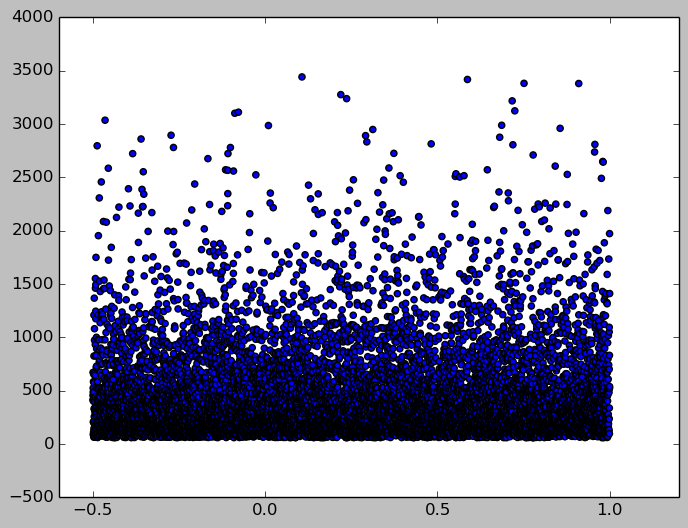

In [120]:
# simple scatter plot to show the spread of avg durations
import matplotlib.pyplot as plt
import numpy as np
pl,ax = plt.subplots()
ax.scatter(np.linspace(-0.5, 1, len(idWithAvgDurationDF['avgSessionDur'])),idWithAvgDurationDF['avgSessionDur'])
plt.show()

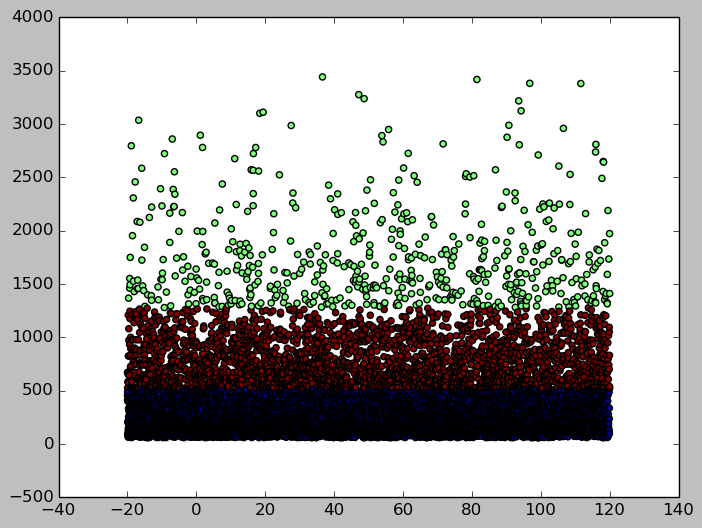

In [121]:
# clustering of avg.durations
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scaledClusteringData = scale(idWithAvgDurationDF.avgSessionDur)
scaledClusteringDataReshape = scaledClusteringData.reshape(-1,1)
# s = []
# for clusterNumber in range(2,4):
#     sessionClusteringKMeans = KMeans(n_clusters=clusterNumber,random_state=0).fit(scaledClusteringDataReshape[:5000])
#     l = silhouette_score(scaledClusteringDataReshape[:5000],sessionClusteringKMeans.labels_,metric='euclidean')
#     s.append(l)
# print s
# plt.plot(s)
# plt.show()
sessionClusteringKMeans = KMeans(n_clusters=3,random_state=0).fit(scaledClusteringDataReshape)
plt.scatter(np.linspace(-20, 120, len(idWithAvgDurationDF['avgSessionDur'])),idWithAvgDurationDF['avgSessionDur'],c=sessionClusteringKMeans.labels_)
# adding the labels to the avg.session.duration
# idWithAvgDurationLabel = idWithAvgDurationDF
# idWithAvgDurationLabel['labels'] = sessionClusteringKMeans.labels_